In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

USE_SAMPLE = True
TRAIN_FACE = './sample/train_face.txt' if USE_SAMPLE else './data/train_face.txt'
TRAIN_USER_INTERACT = './sample/train_interaction.txt' if USE_SAMPLE else './data/train_interaction.txt'
TRAIN_TEXT = './sample/train_text.txt' if USE_SAMPLE else './data/train_text.txt'
TEST_FACE = './sample/test_face.txt' if USE_SAMPLE else './data/test_face.txt'
TEST_INTERACT = './sample/test_interaction.txt' if USE_SAMPLE else './data/test_interaction.txt'
TEST_TEXT = './sample/test_text.txt' if USE_SAMPLE else './data/test_text.txt'

In [2]:
face_train = pd.read_csv(TRAIN_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [3]:
user_item_train = pd.read_csv(TRAIN_USER_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time'])

In [4]:
text_train = pd.read_csv(TRAIN_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [5]:
face_test = pd.read_csv(TEST_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [6]:
user_item_test = pd.read_csv(TEST_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'time', 'duration_time'])

In [7]:
text_test = pd.read_csv(TEST_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [8]:
time_min = min(user_item_train['time'].min(), user_item_test['time'].min())
time_max = max(user_item_train['time'].max(), user_item_test['time'].max())
duration_min = min(user_item_train['duration_time'].min(), user_item_test['duration_time'].min())
duration_max = max(user_item_train['duration_time'].max(), user_item_test['duration_time'].max())

print(time_min, time_max)
print(duration_min, duration_max)
time_df = user_item_train['time']
user_item_train['time'] = (time_df-time_min)/(time_max-time_min)

(760994920751, 761168068776)
(0, 3498)


# 图片被用户浏览数据分布

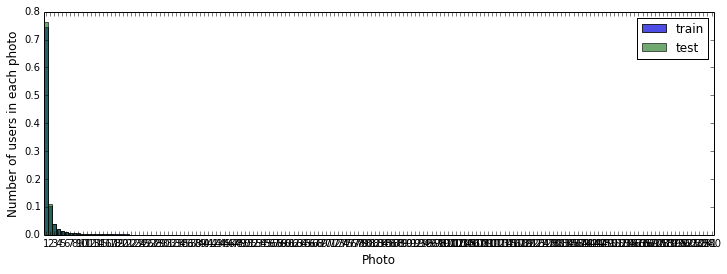

In [9]:
sizes_train = user_item_train.groupby('photo_id')['user_id'].count().value_counts()
sizes_test = user_item_test.groupby('photo_id')['user_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Photo', fontsize=12)
plt.ylabel('Number of users in each photo', fontsize=12)

# 图片文本分类 
由于文字数据集是全的，通过对图片文字描述的分类，可以挖掘图片的隐含语义信息，从而对图片进行分类，可以利用这些分类信息，完成图片id的编码


In [10]:
text_data = pd.concat([text_train, text_test])

text_data['photo_id'].nunique()

text_data['cover_words'] = text_data['cover_words'].apply(lambda words: words.split(','))
text_data['cover_length'] = text_data['cover_words'].apply(lambda words: len(words))

text_data.info()

text_data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337176 entries, 0 to 224394
Data columns (total 3 columns):
photo_id        1337176 non-null int64
cover_words     1337176 non-null object
cover_length    1337176 non-null int64
dtypes: int64(2), object(1)
memory usage: 40.8+ MB


,photo_id,cover_words,cover_length
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18


## 图片文本分类模型
对于图片的文本数据，我们可以通过不同的模型学习和分类图片，首先由文档有两类表示方法，tfidf 和 word2vec/doc2vec, 然后我们可以采用不同的模型进行聚类（隐含语义分类）或者做分类（二分01点击），可以使用K-means,LDA等进行聚类，也可以用 SVM/LR/GBDT等进行分类，最后尝试LSTM深度学习。

### 模型输入数据表征
#### word2vec

In [17]:
num_features = 128
min_word_count = 40
num_workers = 4
context = 6
downsampling = 1e-3

from gensim.models import word2vec
import os
model = None
model_name = "%dfeatures_%dminwords_%dcontext.model" % (num_features, min_word_count, context)
model_name = model_name + ".sample" if USE_SAMPLE else model_name
if not os.path.exists(model_name):
    print "Training model..."
    model = word2vec.Word2Vec(text_data.cover_words,
                              workers=num_workers,
                              size=num_features,
                              min_count = min_word_count,
                              window = context,
                              sample = downsampling)
    model.init_sims(replace=True)
    model.save(model_name)

model = word2vec.Word2Vec.load(model_name)

In [18]:
model.most_similar("1")

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('3484', 0.5905117988586426),
 ('13854', 0.577377438545227),
 ('771', 0.5502607822418213),
 ('1395', 0.5485997796058655),
 ('6552', 0.5481414794921875),
 ('1387', 0.5414555668830872),
 ('1139', 0.536994218826294),
 ('271', 0.5360170602798462),
 ('129', 0.533348798751831),
 ('2336', 0.5321540832519531)]

In [19]:
print(model.corpus_count)
print(len(set(model.wv.index2word)))

1337176
8005


#### doc2vec

In [20]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(model, num_features, words):
    featureVec = np.zeros((num_features,),dtype="float64")
    nwords = 0
    # set for fast query
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords*1.0)
    return featureVec


def getAvgFeatureVecs(covers, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(covers),num_features),dtype="float64")
    for cover in covers:
        if counter%100000 == 0:
            print "Cover %d of %d" % (counter, len(covers))
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(cover, model, \
           num_features)
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [21]:
import functools
doc2vec = functools.partial(makeFeatureVec, model, num_features)
text_data['doc_vec'] = text_data['cover_words'].apply(doc2vec)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [22]:
text_data.head()

,photo_id,cover_words,cover_length,doc_vec
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154,"[-0.025878702781887516, -0.047330769046244246,..."
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154,"[-0.017359135672450066, -0.0212560188619123, -..."
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189,"[-0.01641334203929551, -0.009614278170369608, ..."
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35,"[0.0024094040409716614, 0.019040408003253535, ..."
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18,"[-0.00876109438416149, 0.0368937700654247, 0.0..."


In [23]:
f = 'text_data_docvec'
f = f + '.sample.csv' if USE_SAMPLE else f + '.csv'
text_data['doc_vec'].to_csv(f)

另一种方法是先使用Kmeans对所有的单词做聚类，这可以看成无监督学习出来隐含空间的文本特征属性，每一个类代表一个维度的特征，然后统计一个文本中的单词都属于哪些类的词频作为对应维度的特征值，构成一个DocVector；

这里对文本进行分类可以直接采用得到的Doc2Vec对文本进行聚类，聚类之后，每一个photo就具有类别属性，可以对photo进行编码。

前面的是直接将词向量简单的做平均来构造一个文档的向量DocVector, 当然也可以乘以tf-idf权重。


In [ ]:
USER_FEATURE_TRAIN_FILE = 'user_feature_train'
USER_FEATURE_TRAIN_FILE = USER_FEATURE_TRAIN_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TRAIN_FILE + '.csv'
user_item_train = pd.read_csv(USER_FEATURE_TRAIN_FILE, sep='\t')

USER_FEATURE_TEST_FILE = 'user_feature_test'
USER_FEATURE_TEST_FILE = USER_FEATURE_TEST_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TEST_FILE + '.csv'
user_item_test = pd.read_csv(USER_FEATURE_TEST_FILE, sep='\t')

# 图片的行为交互属性
图片本身被用户交互曝光点击等属性，以及视频时长等属性

In [10]:
items = pd.DataFrame()
common = ['photo_id', 'duration_time', 'time']
items[common] = user_item_train[common]

items['display_num'] = user_item_train['photo_id'].groupby(user_item_train['photo_id']).transform('count')
items['click_num'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('sum')
items['like_num'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('sum')
items['follow_num'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('sum')
items['playing_sum'] = user_item_train['playing_time'].groupby(user_item_train['photo_id']).transform('sum')
items['duration_sum'] = user_item_train['duration_time'].groupby(user_item_train['photo_id']).transform('sum')
items['click_ratio'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('mean')
items['like_ratio'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('mean')
items['follow_ratio'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('mean')
items['playing_ratio'] = items['playing_sum'] / items['duration_sum']


In [11]:
items.drop_duplicates(['photo_id'], inplace=True)

In [12]:
items['photo_id'].nunique()

1112781

In [13]:
import numpy as np
import scipy as sp
from scipy import sparse as ssp
from scipy.stats import spearmanr
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [22]:
items.columns

Index([u'photo_id', u'duration_time', u'time', u'display_num', u'click_num',
       u'like_num', u'follow_num', u'playing_sum', u'duration_sum',
       u'click_ratio', u'like_ratio', u'follow_ratio', u'playing_ratio'],
      dtype='object')

In [23]:
user_item_train.columns

Index([u'user_id', u'photo_id', u'click', u'like', u'follow', u'time',
       u'playing_time', u'duration_time'],
      dtype='object')

In [34]:
cols_to_use = list(items.columns.difference(user_item_train.columns))
cols_to_use

['click_num',
 'click_ratio',
 'display_num',
 'duration_sum',
 'follow_num',
 'follow_ratio',
 'like_num',
 'like_ratio',
 'playing_ratio',
 'playing_sum']

In [35]:
cols_to_use.append('photo_id')
cols_to_use

['click_num',
 'click_ratio',
 'display_num',
 'duration_sum',
 'follow_num',
 'follow_ratio',
 'like_num',
 'like_ratio',
 'playing_ratio',
 'playing_sum',
 'photo_id']

In [36]:
user_features = ['display_num', 'click_num', 'like_num', 'follow_num', 'playing_sum','duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio', 'playing_ratio']
user_item_train = pd.merge(user_item_train, items[cols_to_use],
                          how='inner',
                          on=['photo_id'])
# df2 = pd.merge(a ,df1, on='ID', how='left', suffixes=('_',''))
# df2.drop('value1_', axis=1, inplace=True)
duration_df = user_item_train['duration_time']
user_item_train['duration_time'] = (duration_df-duration_min)/(duration_max-duration_min)

In [47]:
y = user_item_train['click'].values

In [48]:
input_features = ['user_id', 'photo_id', 'time', 'duration_time'] + user_features
user_item_train = user_item_train[input_features]

In [49]:
user_item_train.head()

,user_id,photo_id,time,duration_time,display_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio
0,2,528031,0.451825,0.004574,52,14,0,0,205,832,0.269231,0.0,0.0,0.246394
1,2004,528031,0.219017,0.004574,52,14,0,0,205,832,0.269231,0.0,0.0,0.246394
2,2347,528031,0.588651,0.004574,52,14,0,0,205,832,0.269231,0.0,0.0,0.246394
3,3597,528031,0.472426,0.004574,52,14,0,0,205,832,0.269231,0.0,0.0,0.246394
4,3758,528031,0.451302,0.004574,52,14,0,0,205,832,0.269231,0.0,0.0,0.246394


In [50]:
time_df = user_item_test['time']
user_item_test['time'] = (time_df-time_min)/(time_max-time_min)
duration_df = user_item_test['duration_time']
user_item_test['duration_time'] = (duration_df-duration_min)/(duration_max-duration_min)

In [51]:
user_item_test.head()

,user_id,photo_id,time,duration_time
0,2,8493743,0.975743,0.003145
1,2,8676804,0.975743,0.002001
2,2,8389617,0.987327,0.013436
3,2,9080838,0.975743,0.040023
4,2,8962078,0.987327,0.001144


In [52]:
user_item_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489929 entries, 0 to 489928
Data columns (total 4 columns):
user_id          489929 non-null int64
photo_id         489929 non-null int64
time             489929 non-null float64
duration_time    489929 non-null float64
dtypes: float64(2), int64(2)
memory usage: 15.0 MB


In [53]:
user_item_test = pd.merge(user_item_test, items,
                          how='inner',
                          on=['photo_id'])

In [54]:
user_item_test.head()

,user_id,photo_id,time_x,duration_time_x,duration_time_y,time_y,display_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio


In [ ]:
features = list(set(input_features) - set(['user_id', 'photo_id']))
X = user_item_train.as_matrix(features)

features = input_features.remove('photo_id')
X = user_item_train.as_matrix(features)

In [129]:
np.sum(np.isnan(X))

0

In [130]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [131]:
del user_item_train
gc.collect()

435

In [132]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [134]:
%%time
clf = LogisticRegression(C=1,random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8031740793135325
CPU times: user 18.2 s, sys: 980 ms, total: 19.2 s
Wall time: 19.4 s


In [46]:
%%time
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.80339036 0.80345573 0.80177673 0.80308405 0.80347015]
CPU times: user 1min 11s, sys: 5.73 s, total: 1min 17s
Wall time: 1min 17s


In [47]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.00)


In [ ]:
%%time
param_grid = {
              'C': [1, 10, 100, 500, 1000],
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(LogisticRegression(), param_grid).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

In [ ]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, accuracy_score

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


names = ["Logistic Regression", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=100),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]

for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    print("{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        accuracy_score(y_test, clf.predict(X_test)), recall_score(y_test, clf.predict(X_test), average='macro'), 
        accuracy_score(y_train, clf.predict(X_train)), recall_score(y_train, clf.predict(X_train), average='micro')))
    
for name, clf in zip(names, classifiers):
    try: 
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        print('{}特征权值分布为: '.format(name))
        for f in range(X_train.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    except AttributeError:
        print('{} has no feture_importances_'.format(name))
    
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for name, clf, color in zip(names,classifiers, colors):
    # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    try:
        y_score = clf.decision_function(X_test)
    except AttributeError:
        print('{} has no decision_function'.format(name))
        continue

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} ROC curve (area = {})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], color)  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

Logistic Regression             测试集acc/recall:  0.798934924325/ 0.516325331576 训练集acc/recall:  0.798533275658/ 0.798533275658


In [ ]:
%%time
param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [3, 5, 9, 11, 13, 15, 17],
              'n_estimators': [10, 100, 500, 1000, 2000, 3000, 4000],
              # 'max_features': [1.0, 0.3, 0.1] ## not         possible in our example (only 1 fx)
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs=4).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

In [135]:
X_t = user_item_test.as_matrix(features)
from sklearn import preprocessing
X_t = preprocessing.scale(X_t)
X_t.shape

(489929, 14)

In [136]:
y_sub = clf.predict_proba(X_t)[:,1]
submission = pd.DataFrame()
submission['user_id'] = user_item_test['user_id']
submission['photo_id'] = user_item_test['photo_id']
submission['click_probability'] = y_sub
submission['click_probability'] = submission['click_probability'].apply(lambda x: float('%.6f' % x))
submission.to_csv('sub_lr.txt', sep='\t', index=False, header=False)

In [137]:
submission['click_probability'].describe()

count    489929.000000
mean          0.202159
std           0.128521
min           0.000213
25%           0.113491
50%           0.164768
75%           0.253056
max           0.923619
Name: click_probability, dtype: float64